In [1]:
import pandas as pd; pd.set_option('max_rows', 50)
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['font.family'] = 'Malgun Gothic'
from matplotlib import cm
import seaborn as sns
import warnings; warnings.filterwarnings(action='ignore')

import yfinance as yf # 야후 파이낸스
import bt             # 백테스트 라이브러리
import pyfolio as pf  # 백테스트 시각화 라이브러리
import talib          # 보조지표 라이브러리

# 변수 정의

In [3]:
# 데이터 수집 기간 및 베이스라인 : rolling, 백테스팅을 위해 여분
start_date_pad = '2003-07-29'
end_date_pad   = '2021-10-29'

# 학습 기간
start_date_train = '2003-09-29'
end_date_train   = '2011-09-28'

# 예측 기간
start_date_pred = '2011-09-29'
end_date_pred   = '2021-10-28'

# 백테스트 기간
start_date_bt = '2011-09-29'
end_date_bt   = '2021-09-28'

# # 학습 2기간
# start_date_2p_train = '2003-09-29'
# end_date_2p_train   = '2016-09-28'

# # 벤치마크 기간
# start_date_bench = '2011-07-29'
# end_date_bench   = '2021-10-28'

# # 예측 및 백테스트 1기간
# start_date_1p  = '2011-09-29'
# end_date_1p    = '2016-10-28'
# end_date_1p_bt = '2016-09-28'

# # 예측 및 백테스트 1기간
# start_date_2p  = '2016-09-29'
# end_date_2p    = '2021-10-28'
# end_date_2p_bt = '2021-09-28'

# 주가 데이터 수집

In [4]:
# 지수
indice_tickers = ['^KS11', '^GSPC', '^IXIC',  '^N225',  '^HSI',     '^FCHI', '^GDAXI']
indice_names   = ['kospi', 'sp500', 'nasdaq', 'nikkei', 'hangseng', 'cac',   'dax']

# 지수 추종 ETF   : 코스피,   S&P500,  나스닥,   닛케이,     홍콩,       프랑스,   독일,   미 국채
etf_tickers    = ['EWY',   'SPY',   'QQQ',    'EWJ',    'EWH',      'EWQ',   'EWG', 'AGG']
etf_names      = ['kospi', 'sp500', 'nasdaq', 'nikkei', 'hangseng', 'cac',   'dax', 'agg']

# 지수 OHLCV
indice = yf.download(indice_tickers, start=start_date_pad, end=end_date_pad)
# 지수 추종 OHLCV
etf    = yf.download(etf_tickers, start=start_date_pad, end=end_date_pad)

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  8 of 8 completed


In [5]:
etf['Adj Close']

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
Date,,,,,,,,
2003-07-28,NaN,8.589717,4.700955,24.707077,10.765285,17.662931,27.658079,69.914566
2003-07-29,NaN,8.562790,4.724345,24.390318,10.625308,17.903788,27.449932,69.592506
2003-07-30,NaN,8.475276,4.712650,23.883505,10.695293,17.767307,27.250456,69.424454
2003-07-31,NaN,8.549324,4.765272,24.073563,10.708020,17.422075,27.580029,69.585487
2003-08-01,NaN,8.414693,4.741884,23.788477,10.517147,17.767307,27.285141,68.969376
...,...,...,...,...,...,...,...,...
2021-10-22,113.880913,33.779999,24.680000,68.419998,38.970001,80.360001,374.100006,453.119995
2021-10-25,113.990738,33.810001,24.760000,68.449997,38.639999,81.440002,377.929993,455.549988
2021-10-26,114.200409,33.990002,24.700001,68.459999,38.849998,82.029999,379.119995,455.959991


In [6]:
indice['Adj Close']

,^FCHI,^GDAXI,^GSPC,^HSI,^IXIC,^KS11,^N225
Date,,,,,,,
2003-07-28,3164.929932,3417.770020,996.520020,10134.879883,1735.359985,NaN,NaN
2003-07-29,3142.389893,3428.120117,989.280029,10198.599609,1731.369995,722.330017,9834.309570
2003-07-30,3172.510010,3429.030029,987.489990,10121.219727,1720.910034,714.150024,9632.660156
2003-07-31,3210.270020,3487.860107,990.309998,10134.830078,1735.020020,713.520020,9563.209961
2003-08-01,3169.629883,3438.889893,980.150024,10248.599609,1715.619995,727.260010,9611.669922
...,...,...,...,...,...,...,...
2021-10-22,6733.689941,15542.980469,4544.899902,26126.929688,15090.200195,3006.159912,28804.849609
2021-10-25,6712.870117,15599.230469,4566.479980,26132.029297,15226.709961,3020.540039,28600.410156
2021-10-26,6766.509766,15757.059570,4574.790039,26038.269531,15235.709961,3049.080078,29106.009766


In [7]:
etf['Adj Close']

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
Date,,,,,,,,
2003-07-28,NaN,8.589717,4.700955,24.707077,10.765285,17.662931,27.658079,69.914566
2003-07-29,NaN,8.562790,4.724345,24.390318,10.625308,17.903788,27.449932,69.592506
2003-07-30,NaN,8.475276,4.712650,23.883505,10.695293,17.767307,27.250456,69.424454
2003-07-31,NaN,8.549324,4.765272,24.073563,10.708020,17.422075,27.580029,69.585487
2003-08-01,NaN,8.414693,4.741884,23.788477,10.517147,17.767307,27.285141,68.969376
...,...,...,...,...,...,...,...,...
2021-10-22,113.880913,33.779999,24.680000,68.419998,38.970001,80.360001,374.100006,453.119995
2021-10-25,113.990738,33.810001,24.760000,68.449997,38.639999,81.440002,377.929993,455.549988
2021-10-26,114.200409,33.990002,24.700001,68.459999,38.849998,82.029999,379.119995,455.959991


# 지수와 지수 추종 ETF의 상관관계

In [8]:
pd.concat([indice['Adj Close'], etf['Adj Close']], axis=1).corr().iloc[:7, -7:]

# 코스피 : 0.977490
# sp500 : 0.998325
# 나스닥 : 0.998903
# 닛케이 : 0.976603
# 항셍   : 0.906356
# 프랑스 : 0.883865
# 독일   : 0.952550

,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
^FCHI,0.761684,0.652673,0.891918,0.883865,0.665407,0.657152,0.710768
^GDAXI,0.952550,0.972969,0.902571,0.908758,0.889398,0.886084,0.938418
^GSPC,0.867086,0.918053,0.932788,0.900267,0.838659,0.981866,0.998325
^HSI,0.915971,0.906356,0.755839,0.851663,0.890112,0.661726,0.724927
^IXIC,0.821541,0.884684,0.900776,0.861896,0.822208,0.998903,0.991702
^KS11,0.921939,0.913960,0.783142,0.849054,0.977490,0.796176,0.821399
^N225,0.841868,0.831728,0.976603,0.906331,0.760570,0.875070,0.913039


# 글라이드 패스 함수

In [9]:
def makeGlidePath(etf_ohlcv, glide_weight, risk_weight, start_year):
    
    # 날짜, 위험자산 비중 데이터프레임
    df = pd.DataFrame(
        {
            'Date': [str(year) + '-09-29' for year in range(start_year, 2022)], 
            'RA'  : glide_weight
        }
    )
    
    # 장이 열린 날짜로 조정
    df['Date'] = df.apply(lambda x: etf_ohlcv['Adj Close'].index[etf_ohlcv['Adj Close'].index.get_loc(x['Date'], method='nearest')], axis=1)
    
    # 비위험자산 비중
    df['AGG'] = 1 - df['RA']
    
    # 위험자산 비중
    risk_etfs = ['EWG', 'EWH', 'EWJ', 'EWQ', 'EWY', 'QQQ', 'SPY']
    for risk_etf, weight in zip(risk_etfs, risk_weight):
        df[risk_etf] = df['RA'] * weight
    
    df.set_index('Date', inplace=True)
    df.drop('RA', axis=1, inplace=True)
    
    return df

# baseline 변동성

In [10]:
# 위험자산내 비중 [독일,   홍콩,  일본,   프랑스, 한국,   S&P,   나스닥]
risk_weight   = [.0250, .0250, .0375, .0375, .2500, .2000, .4250]

# baseline 변동성의 글라이드 패스 : 안전자산 없이 위험자산으로만 구성(가장 큰 변동성 확인 가능)
gw_baseline = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
gp_baseline = makeGlidePath(etf, gw_baseline, risk_weight, start_year=int(start_date_pad[:4]))
gp_baseline

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
Date,,,,,,,,
2003-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2004-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2005-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2006-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2007-09-28,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2008-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2009-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2010-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2011-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425


In [11]:
# 백테스팅의 데이터
baseline_data = etf['Adj Close'].loc[start_date_pad:]

# 백테스팅 전략
baseline_strategy = bt.Strategy(
    'baseline', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_baseline), 
        bt.algos.Rebalance(), 
    ]
)

# 백테스트
baseline_backtest = bt.Backtest(strategy=baseline_strategy, data=baseline_data)
baseline_result   = bt.run(baseline_backtest)

In [12]:
baseline_result.stats # 백테스트 요약 결과

,baseline
start,2003-07-28 00:00:00
end,2021-10-28 00:00:00
rf,0.0
total_return,5.808829
cagr,0.11081
max_drawdown,-0.58885
calmar,0.18818
mtd,0.047526
three_month,0.004281
six_month,0.033244


## 백테스트 결과 시각화

<AxesSubplot:>

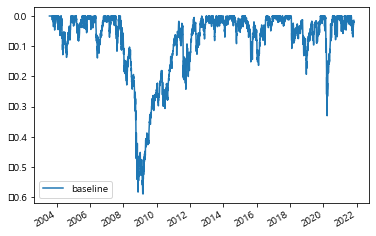

In [13]:
%matplotlib inline
baseline_result.prices.to_drawdown_series().plot() # MDD(최대낙폭)

<AxesSubplot:>

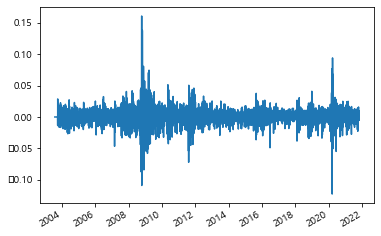

In [14]:
baseline_returns = baseline_result.prices.to_returns().iloc[1:, 0]
baseline_returns.plot() # 일별 수익률

Start date,2003-07-29
End date,2021-10-28
Total months,218
,Backtest
Annual return,11.088%
Cumulative returns,580.883%
Annual volatility,20.803%
Sharpe ratio,0.61
Calmar ratio,0.19
Stability,0.91
Max drawdown,-58.885%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,58.89,2007-10-31,2009-03-09,2012-09-13,1272
1,32.98,2020-02-12,2020-03-23,2020-07-22,116
2,19.28,2018-01-26,2018-12-24,2019-10-28,457
3,16.33,2015-04-28,2016-02-11,2016-07-29,329
4,13.88,2006-05-08,2006-06-13,2006-11-07,132


Stress Events,mean,min,max
Lehman,-0.31%,-8.70%,4.61%
US downgrade/European Debt Crisis,-0.12%,-7.20%,5.04%
Fukushima,0.25%,-2.17%,1.84%
EZB IR Event,-0.04%,-1.29%,1.76%
Aug07,0.02%,-3.32%,3.33%
Mar08,0.18%,-2.53%,4.17%
Sept08,-0.49%,-8.70%,4.61%
2009Q1,-0.46%,-5.78%,4.42%
2009Q2,0.57%,-5.07%,7.44%
Flash Crash,-0.12%,-3.48%,5.13%


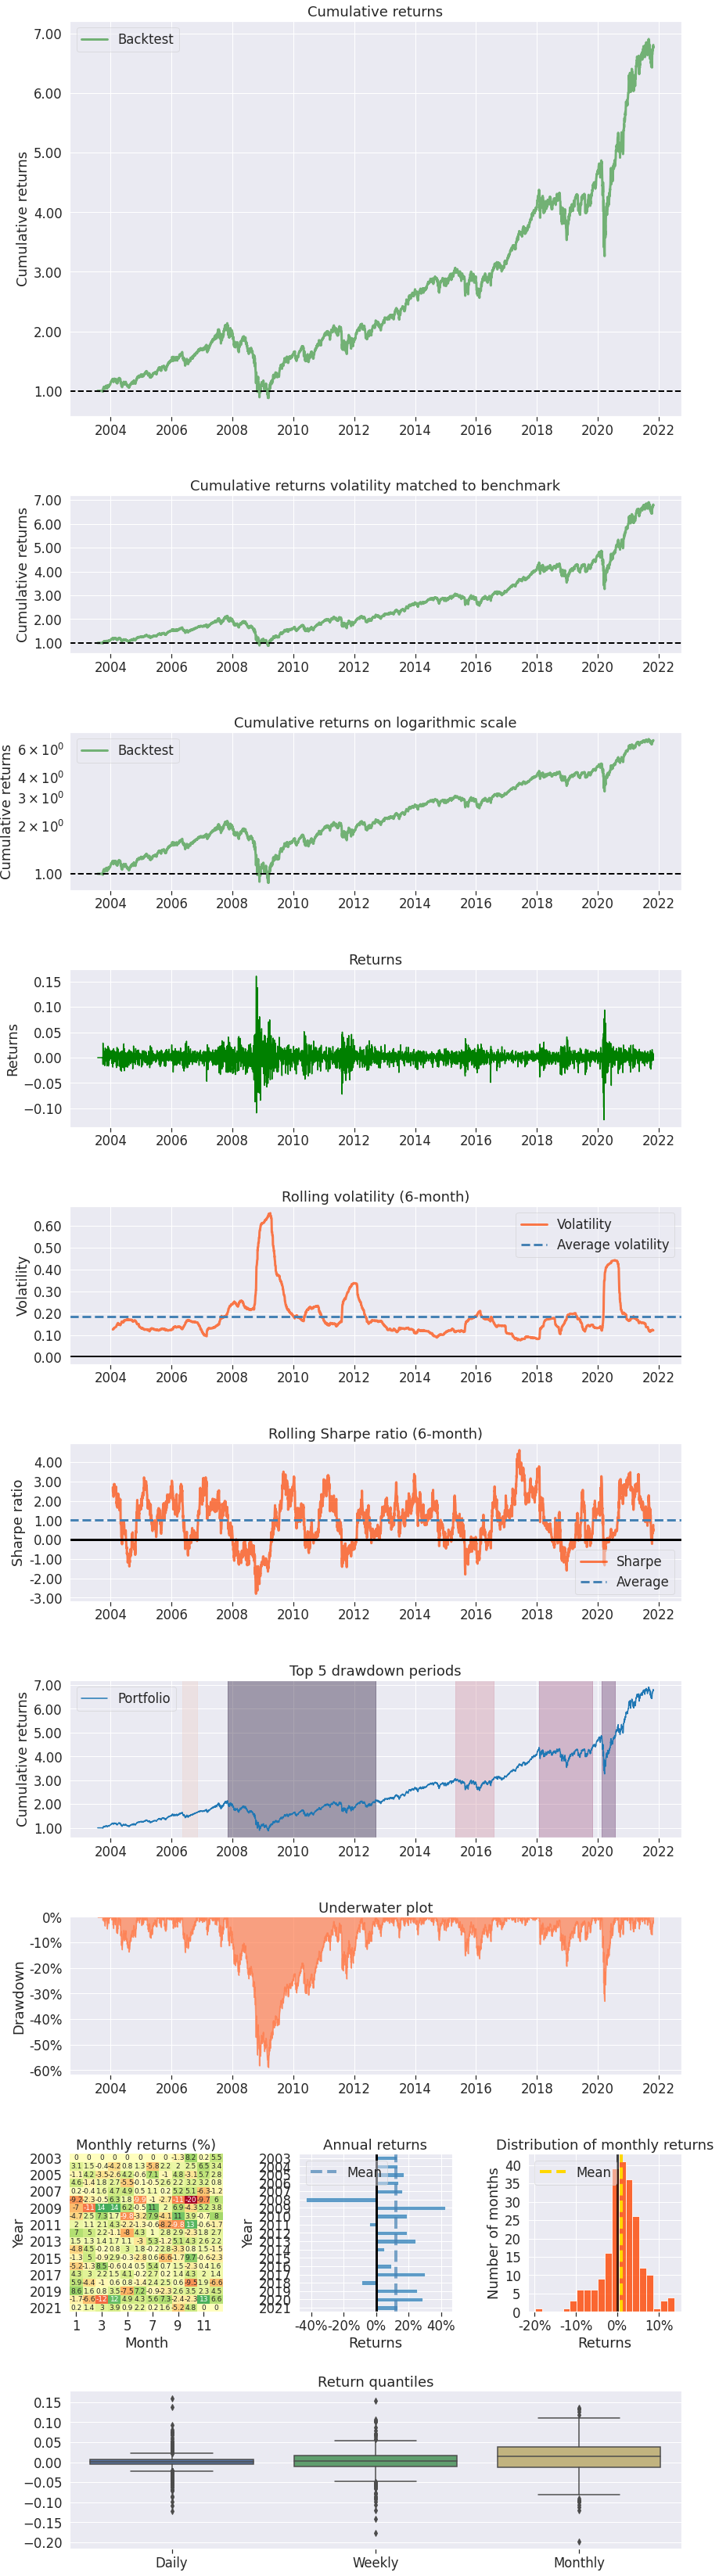

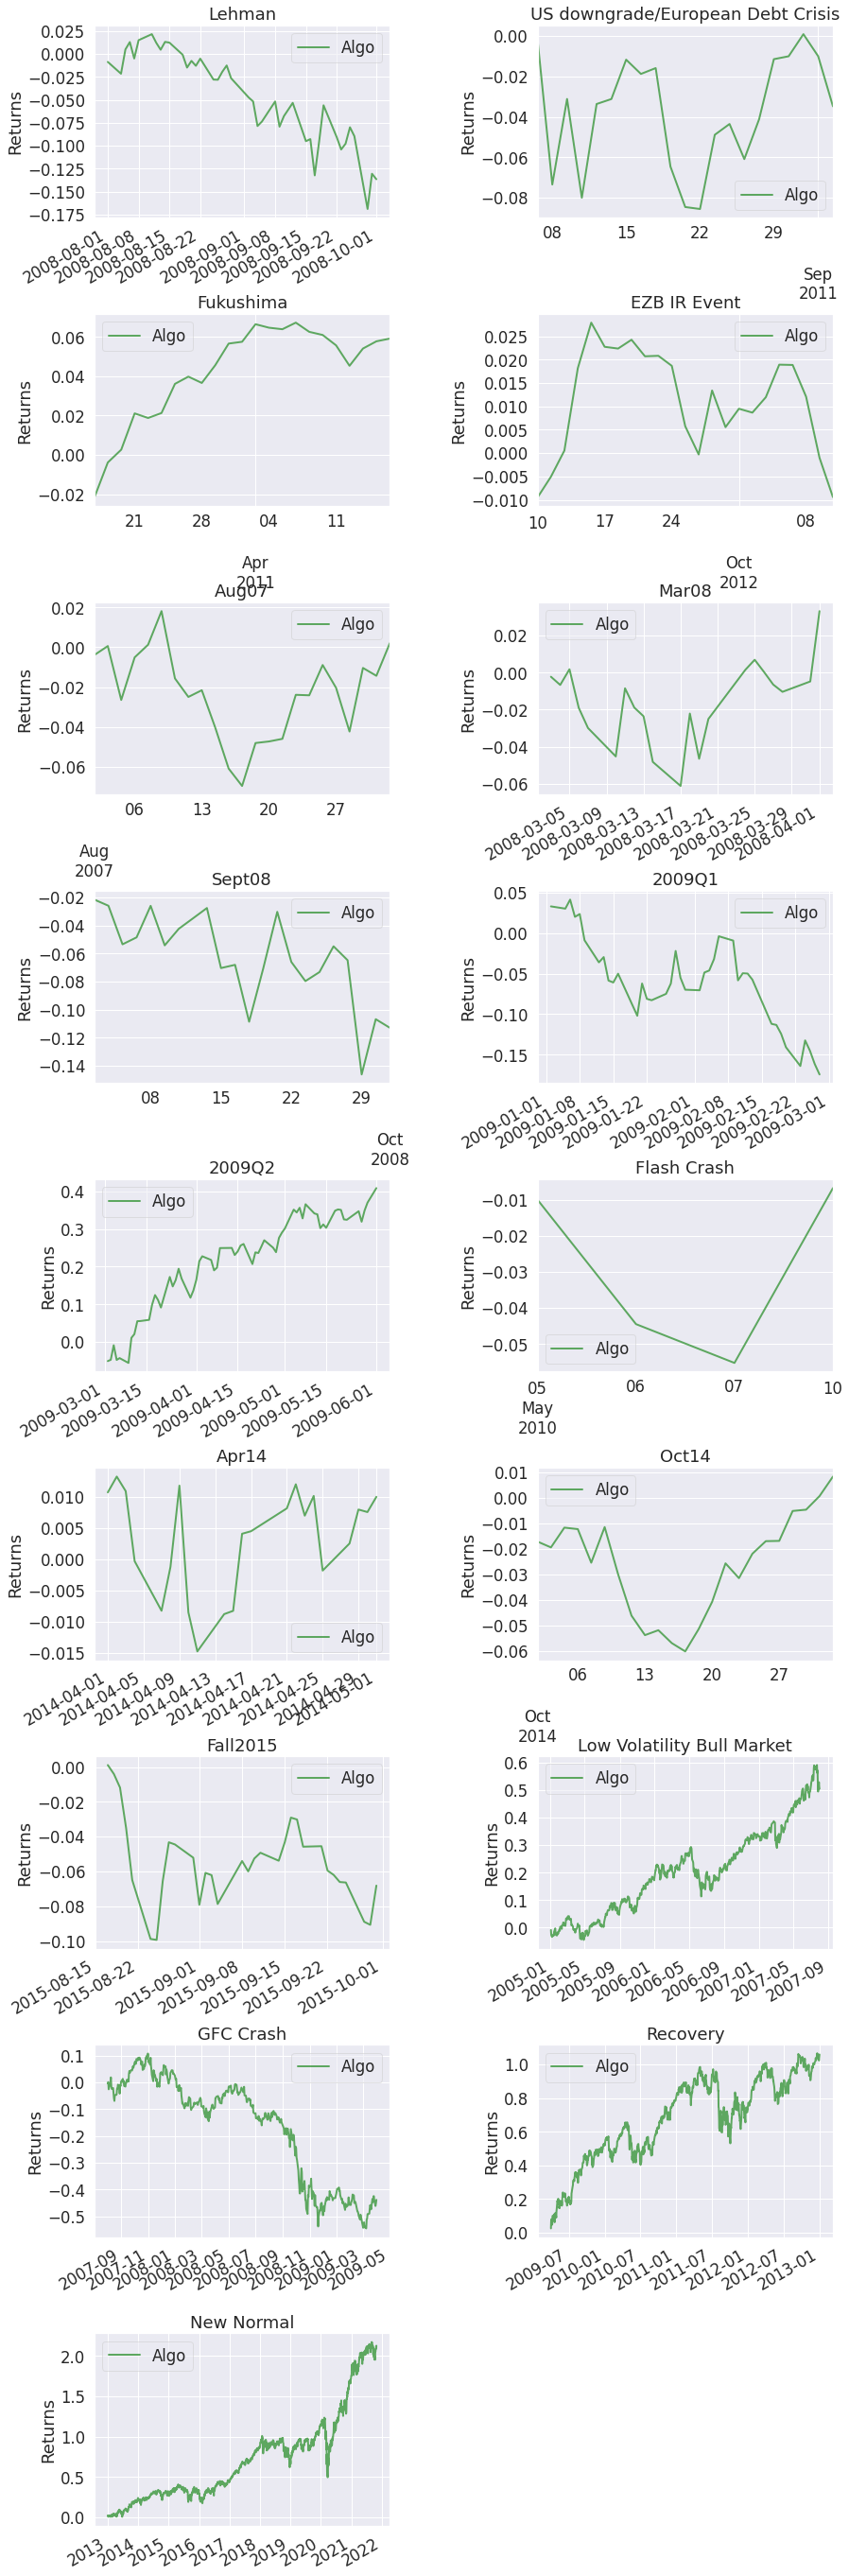

In [15]:
# pyfolio 종합 plot
pf.create_full_tear_sheet(baseline_returns)

<AxesSubplot:title={'center':'Top 10 drawdown periods'}, ylabel='Cumulative returns'>

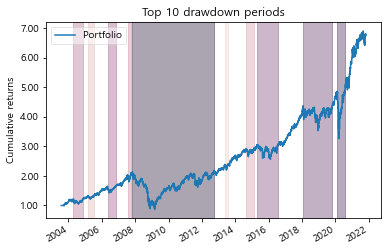

In [16]:
pf.plot_drawdown_periods(returns=baseline_returns, top=10)

<AxesSubplot:ylabel='Returns'>

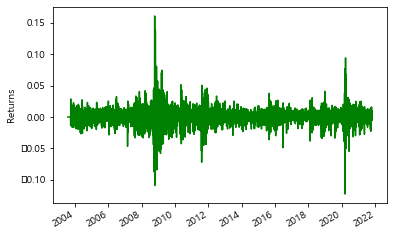

In [17]:
pf.plot_returns(baseline_returns)

<AxesSubplot:title={'center':'Annual returns'}, xlabel='Returns', ylabel='Year'>

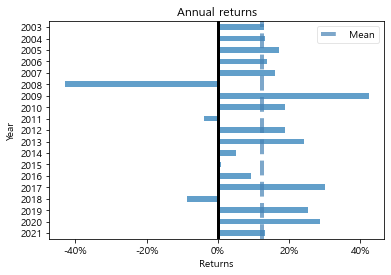

In [18]:
pf.plot_annual_returns(baseline_returns)

<AxesSubplot:title={'center':'Underwater plot'}, ylabel='Drawdown'>

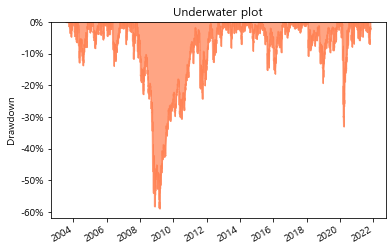

In [19]:
pf.plot_drawdown_underwater(baseline_returns)

<AxesSubplot:title={'center':'Distribution of monthly returns'}, xlabel='Returns', ylabel='Number of months'>

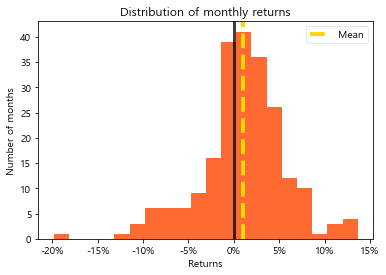

In [20]:
pf.plot_monthly_returns_dist(baseline_returns)

<AxesSubplot:title={'center':'Monthly returns (%)'}, xlabel='Month', ylabel='Year'>

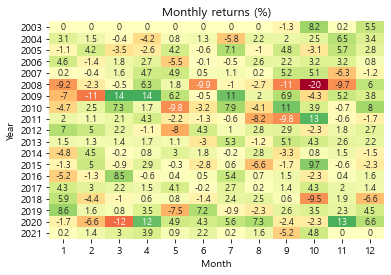

In [21]:
pf.plot_monthly_returns_heatmap(baseline_returns)

<AxesSubplot:>

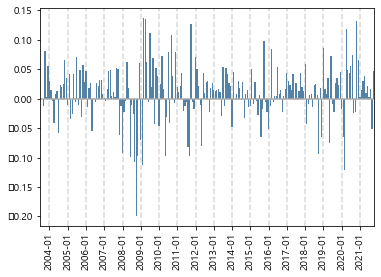

In [22]:
pf.plot_monthly_returns_timeseries(baseline_returns)

<AxesSubplot:title={'center':'Return quantiles'}>

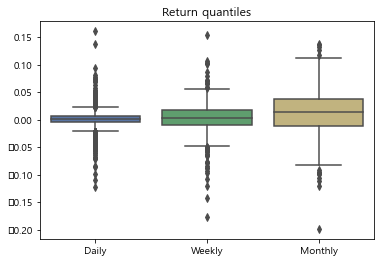

In [23]:
pf.plot_return_quantiles(baseline_returns)

<AxesSubplot:ylabel='Cumulative returns'>

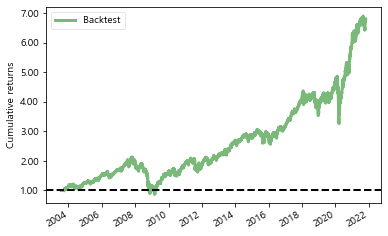

In [24]:
pf.plot_rolling_returns(baseline_returns)

<AxesSubplot:title={'center':'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

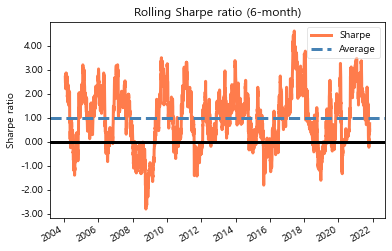

In [25]:
pf.plot_rolling_sharpe(baseline_returns)

<AxesSubplot:title={'center':'Rolling volatility (6-month)'}, ylabel='Volatility'>

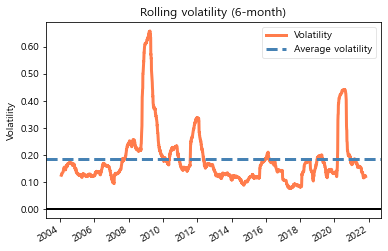

In [26]:
pf.plot_rolling_volatility(baseline_returns)

## baseline 변동성 데이터

In [27]:
baseline_hv = baseline_result.prices
baseline_hv['HV']          = baseline_hv.iloc[:, 0].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)
baseline_hv['HV_pred_5']   = baseline_hv.iloc[:, 1].shift(-5)
baseline_hv['HV_pred_10']  = baseline_hv.iloc[:, 1].shift(-10)
baseline_hv['HV_pred_15']  = baseline_hv.iloc[:, 1].shift(-15)
baseline_hv['HV_pred_20']  = baseline_hv.iloc[:, 1].shift(-20)
baseline_hv['HV_resid_5']  = baseline_hv.iloc[:, 1].diff(-5)
baseline_hv['HV_resid_10'] = baseline_hv.iloc[:, 1].diff(-10)
baseline_hv['HV_resid_15'] = baseline_hv.iloc[:, 1].diff(-15)
baseline_hv['HV_resid_20'] = baseline_hv.iloc[:, 1].diff(-20)

baseline_hv

,baseline,HV,HV_pred_5,HV_pred_10,HV_pred_15,HV_pred_20,HV_resid_5,HV_resid_10,HV_resid_15,HV_resid_20
2003-07-28,100.000000,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2003-07-29,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-07-30,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-07-31,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-08-01,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-10-22,671.965986,0.140721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-25,676.977984,0.142860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26,679.063830,0.115054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-27,675.510104,0.116818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 보조지표

### 사전정의함수

In [28]:
def getPsy(x):
    if x > 0:
        result = 1
    else:
        result = np.nan
    return result

def getRevPlus(a):
    if a > 0:
        result = a
    else:
        result = 0
    return result

def getRevMinus(a):
    if a < 0:
        result = a
    else:
        result = 0
    return result

def getVRplus(a, b):
    if a > 0:
        result = b
    else:
        result = 0
    return result

def getVRminus(a, b):
    if a < 0:
        result = b
    else:
        result = 0
    return result

### 보조지표 함수

In [29]:
def getIndicators(df):
    
    # Change : 변동률
    df['Change'] = df['Adj Close'].pct_change()
    
    # Moving Average : 주가이동평균
    df['MA5'] = talib.MA(df['Adj Close'], timeperiod=5)
    df['MA20'] = talib.MA(df['Adj Close'], timeperiod=20)
    df['MA60'] = talib.MA(df['Adj Close'], timeperiod=60)
    df['MA120'] = talib.MA(df['Adj Close'], timeperiod=120)
    # 가격이동평균 기울기 : (당일 이동평균 - 전날 이동평균) / 전날 이동평균
    df['MA5_gra'] = (df['MA5'] - df['MA5'].shift(1)) / df['MA5'].shift(1)
    df['MA20_gra'] = (df['MA20'] - df['MA20'].shift(1)) / df['MA20'].shift(1)
    df['MA60_gra'] = (df['MA60'] - df['MA60'].shift(1)) / df['MA60'].shift(1)
    df['MA120_gra'] = (df['MA120'] - df['MA120'].shift(1)) / df['MA120'].shift(1)    
    
    # 거래량이동평균
    df['V_MA5'] = talib.MA(df['Volume'], timeperiod=5)
    df['V_MA20'] = talib.MA(df['Volume'], timeperiod=20)
    df['V_MA60'] = talib.MA(df['Volume'], timeperiod=60)
    df['V_MA120'] = talib.MA(df['Volume'], timeperiod=120)
    
    # 지수이동평균
    df['EMA5'] = talib.EMA(df['Adj Close'], timeperiod=5)
    df['EMA20'] = talib.EMA(df['Adj Close'], timeperiod=20)
    df['EMA60'] = talib.EMA(df['Adj Close'], timeperiod=60)
    df['EMA120'] = talib.EMA(df['Adj Close'], timeperiod=120)   
    
    # MACD
    macd, macdsignal, macdhist = talib.MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = macd
    df['MACD_sig9'] = macdsignal
    df['MACD_OSC'] = macdhist
    
    # Stochastic
    fastk, fastd = talib.STOCHF(df['High'], df['Low'], df['Adj Close'], fastk_period=14, fastd_period=3)
    slowk, slowd = talib.STOCH(df['High'], df['Low'], df['Adj Close'], fastk_period=14, slowk_period=5, slowd_period=3)
    df['Fast%K'] = fastk
    df['Fast%D'] = fastd
    df['Slow%K'] = slowk
    df['Slow%D'] = slowd
    
    # RSI: 9일, 14일, 15일, 25일, 28일 (RSI_sig 9일)
    df_index = df.index.astype('str')
    U = np.where(df['Adj Close'].diff(1) > 0, df['Adj Close'].diff(1), 0)
    D = np.where(df['Adj Close'].diff(1) < 0, df['Adj Close'].diff(1)*(-1), 0)
    AU = pd.DataFrame(U, index = df_index).rolling(window=14).mean() # RSI: 14일
    AD = pd.DataFrame(D, index = df_index).rolling(window=14).mean()
    RSI = AU / (AD+AU) * 100
    
    df.insert(len(df.columns), "RSI14", RSI)
    df.insert(len(df.columns), "RSI signal", df['RSI14'].ewm(span=9).mean())
    
    # CCI (14일 기준)
    M = (df['High']+df['Low']+df['Adj Close'])/3
    m = M.rolling(window=14).mean()
    d = abs(M-m).rolling(window=14).mean()
    df['CCI'] =( M - m )/(d*0.015)
    df['CCI'] = np.where(df['CCI'] > 0, df['CCI'] + 0.5, df['CCI'] - 0.5)
    
    # A ratio
    df['A'] = (df['High'] - df['Open']).rolling(window=20).sum() / (df['Open'] - df['Low']).rolling(window=20).sum()
    df['A_Ratio'] = df['A']*100
    
    # B ratio
    df['B'] = (df['High'] - df['Adj Close'].shift(1)).rolling(window=20).sum() / (df['Adj Close'].shift(1) - df['Low']).rolling(window=20).sum()
    df['B_Ratio'] = df['B']*100
    
    
    df.drop(['A', 'B'], axis=1, inplace=True)
    
    # ATR(14일 기준)
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Adj Close'], timeperiod=14)
    
    # DMI
    df['UpDI'] = talib.PLUS_DI(df['High'], df['Low'],  df['Adj Close'], timeperiod=14)
    df['DownDI'] = talib.MINUS_DI(df['High'], df['Low'],  df['Adj Close'], timeperiod=14)
    
    # MFI
    df['MFI'] = talib.MFI(df['High'], df['Low'], df['Adj Close'], df['Volume'], timeperiod=14)
    
    # Momentum
    df['Momentum'] = talib.MOM(df['Adj Close'], timeperiod=12)
    
    # Sonar
    df['EMA9'] = talib.EMA(df['Adj Close'], timeperiod=9)
    df['n_shift_ema'] = df['EMA9'].shift(9)
    df['Sonar'] = df['EMA9'] - df['n_shift_ema']
    df['Sonar_sig5'] = talib.EMA(df['Sonar'], timeperiod=5)
    
    df.drop('EMA9', axis=1, inplace= True)
    
    df.drop('n_shift_ema', axis=1, inplace=True)
    
    # STDEV(20일 표준편차)
    df['STDEV'] = talib.STDDEV(df['Adj Close'], timeperiod=20)
    
    # Sigma(20일) (20일짜리 표준편차 사용)
    df['Sigma'] = ( df['Adj Close'] - df['Adj Close'].rolling(window=20).mean() ) / df['STDEV']
    
    # TRIX(12일) (퍼센트)
    df['TRIX'] = talib.TRIX(df['Adj Close'], timeperiod=12)
    
    # VR : 주가 상승일 거래량 / 주가 하락일 거래량 * 100, 
    df['VRplus']  = df.apply(lambda x: getVRplus(x['Change'], x['Volume']), axis=1)
    df['VRminus'] = df.apply(lambda x: getVRminus(x['Change'], x['Volume']), axis=1)
    
    df['VRplus_rolling']  = df['VRplus'].rolling(window=20).sum() # period: 20
    df['VRminus_rolling'] = df['VRminus'].rolling(window=20).sum()
    
    df['VR'] = df['VRplus_rolling'] / df['VRminus_rolling'] * 100
    
    df.drop(['VRplus', 'VRminus', 'VRplus_rolling', 'VRminus_rolling'], axis=1, inplace=True)
    
    # William's %R (14일)
    df['WILLR'] = talib.WILLR(df['High'], df['Low'], df['Adj Close'], timeperiod=14)
    
    # 심리도
    df['psy_temp'] = df.apply(lambda x: getPsy(x['Change']), axis=1)
    df['Psy']      = df['psy_temp'].rolling(window=10).count() / 10 * 100
    df.drop('psy_temp', axis=1, inplace=True)
    
    # 이격도
    df['Disparity20'] = (df['Adj Close'] / df['Adj Close'].rolling(window=20).mean()) * 100
    df['Disparity60'] = (df['Adj Close'] / df['Adj Close'].rolling(window=60).mean()) * 100
    
    # ADX
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Adj Close'], timeperiod=14)
    
    # Chaikin's OSC
    df['ADOSC'] = talib.ADOSC(df['High'], df['Low'], df['Adj Close'], df['Volume'], fastperiod=3, slowperiod=10)
    
    # 거래량 OSC(10일, 20일, 9일)
    df['Volume_OSC'] = (df['Volume'].rolling(window=10).mean() - df['Volume'].rolling(window=20).mean()) / df['Volume'].rolling(window=10).mean() * 100
    
    # 볼린저 밴드
    df['upperband'], df['middleband'], df['lowerband'] = talib.BBANDS(df['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    
    
    return df

### 보조지표 생성

In [30]:
sum_word = pd.read_csv('./sum_word.csv')
sum_word['date'] = pd.to_datetime(sum_word['date'])
baseline_hv = baseline_hv.merge(sum_word, how='left', left_index=True, right_on='date')

etfs = []
# ['EWG', 'EWH', 'EWJ', 'EWQ', 'EWY', 'QQQ', 'SPY']
for i, j in zip(etf['Adj Close'].columns[1:], risk_weight):
    temp_etf = getIndicators(etf.swaplevel(axis=1)[i])
    temp_etf.fillna(0, inplace=True)
    temp_etf = temp_etf.loc[:, 'MA5':] * j
    etfs.append(temp_etf)

baseline_hv = baseline_hv.merge(sum(etfs), how='left', left_on='date', right_index=True)
baseline_hv.set_index('date', inplace=True)
baseline_hv

,baseline,HV,HV_pred_5,HV_pred_10,HV_pred_15,HV_pred_20,HV_resid_5,HV_resid_10,HV_resid_15,HV_resid_20,...,WILLR,Psy,Disparity20,Disparity60,ADX,ADOSC,Volume_OSC,upperband,middleband,lowerband
date,,,,,,,,,,,,,,,,,,,,,
2003-07-28,100.000000,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.000000,0.000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2003-07-29,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,2.750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2003-07-30,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,3.125,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2003-07-31,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,10.625,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2003-08-01,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,13.125,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-22,671.965986,0.140721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-11.522496,61.750,102.241485,100.217535,21.733995,4.102616e+07,-24.072622,295.681766,285.123539,274.565311
2021-10-25,676.977984,0.142860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-4.367299,71.000,102.950515,100.954263,21.396078,4.306214e+07,-24.804775,296.701135,285.447644,274.194154
2021-10-26,679.063830,0.115054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-11.088321,80.125,103.079400,101.251089,21.534014,3.273070e+07,-22.229806,298.022674,286.125394,274.228114


In [34]:
hv_resid_mean = baseline_hv.loc[start_date_train:end_date_train, 'HV_resid_5':'HV_resid_20'].mean().values
hv_resid_std  = baseline_hv.loc[start_date_train:end_date_train, 'HV_resid_5':'HV_resid_20'].std(ddof=0).values
print(hv_resid_mean)
print(hv_resid_std)

[-0.00061147 -0.00112474 -0.00162432 -0.00195433]
[0.03692308 0.05987976 0.08102325 0.09914344]


<AxesSubplot:xlabel='date', ylabel='HV'>

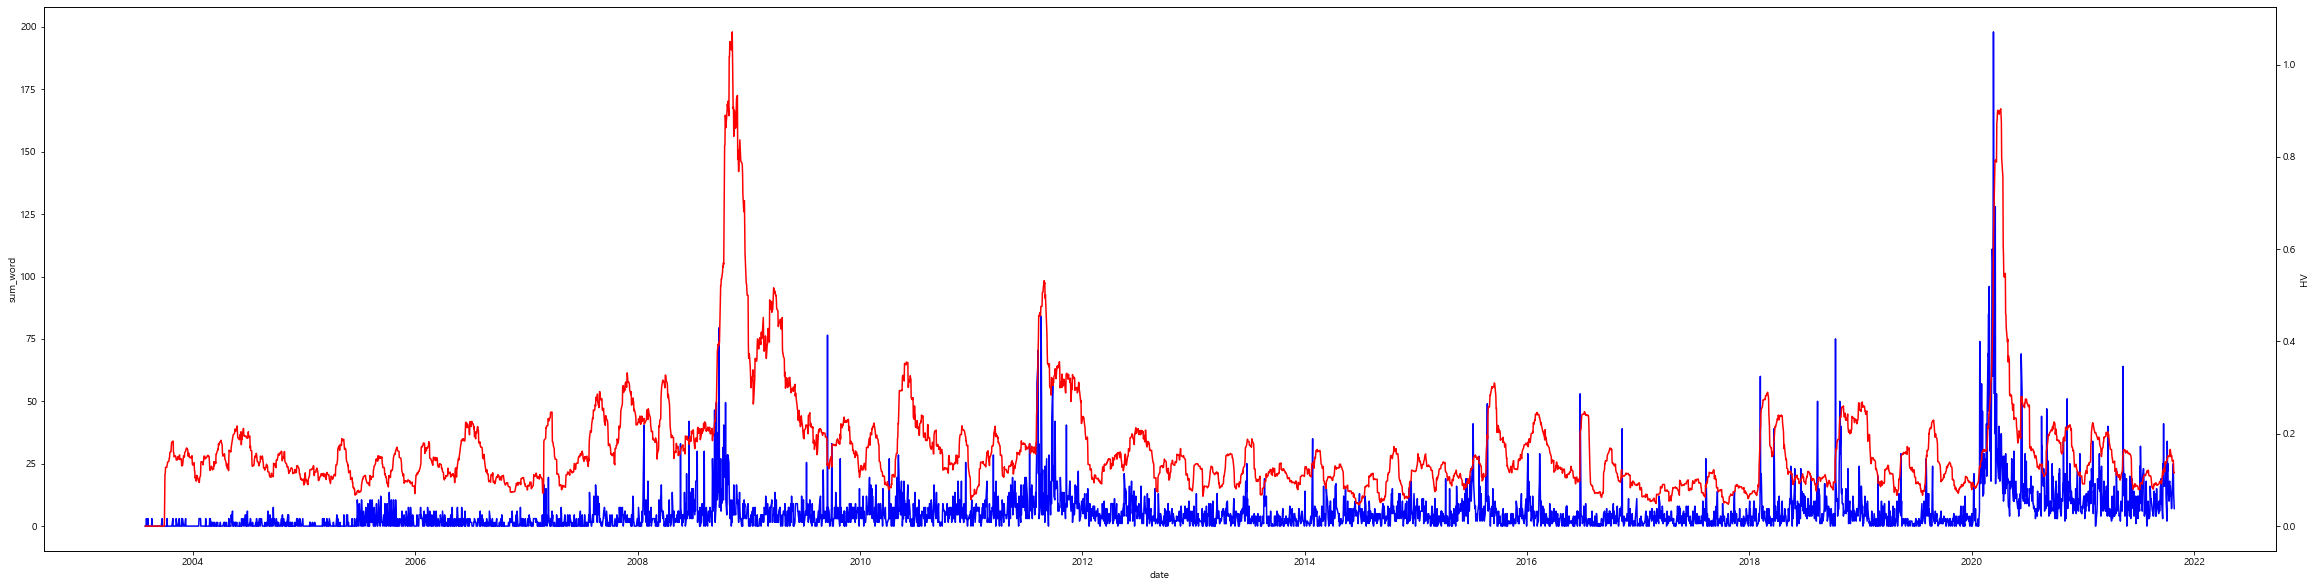

In [32]:
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()

sns.lineplot(ax=ax1, color='b', y=baseline_hv['sum_word'], x=baseline_hv.index)
sns.lineplot(ax=ax2, color='r', y=baseline_hv['HV'], x=baseline_hv.index)

In [33]:
# baseline_hv.to_csv('./baseline_hv.csv')

# 벤치마크 포트폴리오

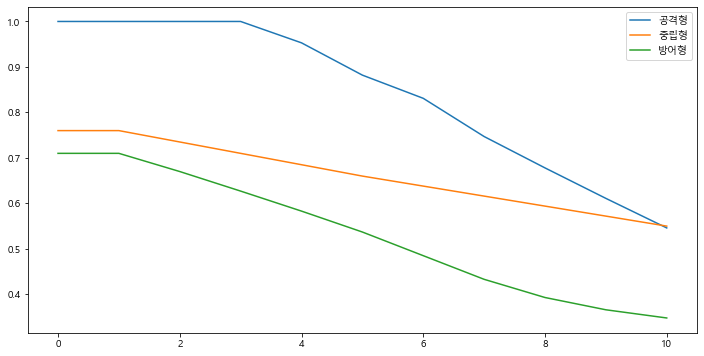

In [35]:
# 10년 벤치마크 글라이드 패스 비중
glide_weight_att = [1.000, 1.000, 1.000, 1.000, .9530, .8820, .8310, .7470, .6780, .6110, .5460]
glide_weight_neu = [.7600, .7600, .7350, .7100, .6850, .6600, .6380, .6160, .5940, .5720, .5500]
glide_weight_def = [.7100, .7100, .6700, .6270, .5830, .5370, .4850, .4330, .3930, .3660, .3480]

# 3년 벤치마크 글라이드 패스 비중
# glide_weight_att = [1.000, 1.000, .8820, .5460]
# glide_weight_neu = [.7600, .7600, .6600, .5500]
# glide_weight_def = [.7100, .7100, .5370, .3480]

f = plt.subplots(figsize=(12, 6))   
sns.lineplot(x=range(len(glide_weight_att)), y=glide_weight_att, label='공격형')
sns.lineplot(x=range(len(glide_weight_att)), y=glide_weight_neu, label='중립형')
sns.lineplot(x=range(len(glide_weight_att)), y=glide_weight_def, label='방어형')
plt.show()

In [36]:
# 벤치마크 글라이드 패스
gp_bench_att = makeGlidePath(etf, glide_weight_att, risk_weight, start_year=int(start_date_bt[:4]))
gp_bench_neu = makeGlidePath(etf, glide_weight_neu, risk_weight, start_year=int(start_date_bt[:4]))
gp_bench_def = makeGlidePath(etf, glide_weight_def, risk_weight, start_year=int(start_date_bt[:4]))

gp_bench_att

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
Date,,,,,,,,
2011-09-29,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2012-09-28,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2013-09-30,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2014-09-29,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2015-09-29,0.047,0.023825,0.023825,0.035737,0.035737,0.23825,0.1906,0.405025
2016-09-29,0.118,0.022050,0.022050,0.033075,0.033075,0.22050,0.1764,0.374850
2017-09-29,0.169,0.020775,0.020775,0.031162,0.031162,0.20775,0.1662,0.353175
2018-09-28,0.253,0.018675,0.018675,0.028012,0.028012,0.18675,0.1494,0.317475
2019-09-30,0.322,0.016950,0.016950,0.025425,0.025425,0.16950,0.1356,0.288150


In [40]:
data = etf['Adj Close'].loc[start_date_pred:end_date_pred]

bench_att = bt.Strategy(
    'bench_att', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bench_att), 
        bt.algos.Rebalance(), 
    ]
)

bench_neu = bt.Strategy(
    'bench_neu', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bench_neu), 
        bt.algos.Rebalance(), 
    ]
)

bench_def = bt.Strategy(
    'bench_def', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bench_def), 
        bt.algos.Rebalance(), 
    ]
)

bench_att_backtest = bt.Backtest(strategy=bench_att, data=data)
bench_neu_backtest = bt.Backtest(strategy=bench_neu, data=data)
bench_def_backtest = bt.Backtest(strategy=bench_def, data=data)

bench_result = bt.run(bench_att_backtest, bench_neu_backtest, bench_def_backtest)
bench_hv = bench_result.prices
bench_hv

,bench_att,bench_neu,bench_def
2011-09-28,100.000000,100.000000,100.000000
2011-09-29,100.000000,100.000000,100.000000
2011-09-30,96.894486,97.729418,97.903704
2011-10-03,94.167332,95.755109,96.086563
2011-10-04,96.395758,97.374273,97.578540
...,...,...,...
2021-10-22,332.150720,280.237193,245.346847
2021-10-25,333.666611,281.523281,246.149940
2021-10-26,334.510608,282.236746,246.711767
2021-10-27,334.030233,281.821746,246.777154


In [41]:
for col in bench_hv.columns:
    bench_hv[col + '_HV']          = bench_hv[col].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)
    bench_hv[col + '_HV_pred_5']   = bench_hv[col + '_HV'].shift(-5)
    bench_hv[col + '_HV_pred_10']  = bench_hv[col + '_HV'].shift(-10)
    bench_hv[col + '_HV_pred_15']  = bench_hv[col + '_HV'].shift(-15)
    bench_hv[col + '_HV_pred_20']  = bench_hv[col + '_HV'].shift(-20)
    bench_hv[col + '_HV_resid_5']  = bench_hv[col + '_HV'].diff(-5)
    bench_hv[col + '_HV_resid_10'] = bench_hv[col + '_HV'].diff(-10)
    bench_hv[col + '_HV_resid_15'] = bench_hv[col + '_HV'].diff(-15)
    bench_hv[col + '_HV_resid_20'] = bench_hv[col + '_HV'].diff(-20)

bench_hv = bench_hv[start_date_bt:end_date_bt]
bench_hv

,bench_att,bench_neu,bench_def,bench_att_HV,bench_att_HV_pred_5,bench_att_HV_pred_10,bench_att_HV_pred_15,bench_att_HV_pred_20,bench_att_HV_resid_5,bench_att_HV_resid_10,...,bench_neu_HV_resid_20,bench_def_HV,bench_def_HV_pred_5,bench_def_HV_pred_10,bench_def_HV_pred_15,bench_def_HV_pred_20,bench_def_HV_resid_5,bench_def_HV_resid_10,bench_def_HV_resid_15,bench_def_HV_resid_20
2011-09-29,100.000000,100.000000,100.000000,0.000000,0.360795,0.324120,0.305722,0.329484,-0.360795,-0.324120,...,-0.243649,0.000000,0.240327,0.219153,0.207622,0.225634,-0.240327,-0.219153,-0.207622,-0.225634
2011-09-30,96.894486,97.729418,97.903704,0.246493,0.335629,0.316654,0.303503,0.302691,-0.089136,-0.070162,...,-0.043594,0.166388,0.224014,0.214405,0.206889,0.207247,-0.057626,-0.048017,-0.040500,-0.040859
2011-10-03,94.167332,95.755109,96.086563,0.222310,0.372742,0.323141,0.303095,0.305007,-0.150432,-0.100831,...,-0.065348,0.148701,0.252210,0.218677,0.207006,0.210159,-0.103510,-0.069976,-0.058305,-0.061458
2011-10-04,96.395758,97.374273,97.578540,0.355045,0.352094,0.317428,0.307938,0.318359,0.002951,0.037616,...,0.019175,0.235602,0.238040,0.215161,0.209927,0.219601,-0.002438,0.020441,0.025676,0.016001
2011-10-05,98.063524,98.560736,98.664513,0.358457,0.338130,0.313584,0.300349,0.318000,0.020328,0.044873,...,0.020808,0.237141,0.228639,0.212741,0.204687,0.219952,0.008502,0.024400,0.032453,0.017189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-22,332.858737,280.739331,247.178971,0.077053,0.092423,0.095782,0.098514,0.092232,-0.015370,-0.018729,...,-0.017214,0.050837,0.060871,0.063626,0.065744,0.063069,-0.010034,-0.012789,-0.014907,-0.012232
2021-09-23,335.484602,282.759532,247.990907,0.082518,0.090481,0.098146,0.105341,0.087583,-0.007963,-0.015628,...,-0.008455,0.052376,0.059420,0.064590,0.070900,0.061735,-0.007044,-0.012214,-0.018525,-0.009359
2021-09-24,334.226530,281.729650,247.239748,0.081647,0.093290,0.097839,0.104335,0.086816,-0.011643,-0.016192,...,-0.008472,0.052211,0.062292,0.064347,0.069866,0.061271,-0.010081,-0.012136,-0.017655,-0.009060
2021-09-27,333.807669,281.374534,246.918130,0.076160,0.094719,0.096808,0.094003,0.088328,-0.018559,-0.020648,...,-0.015407,0.047103,0.063477,0.063308,0.064874,0.062435,-0.016374,-0.016205,-0.017771,-0.015332


## 전략별 비교

In [47]:
# ax = bench_result.get_security_weights(backtest='bench_att').plot.area(
#     figsize=(9, 6), legend=False, colormap=cm.jet_r, ylim=[0, 1]
# )
# handles, labels = ax.get_legend_handles_labels()
# plt.margins(0, 0)
# plt.legend(reversed(handles), reversed(labels), loc='lower right')

In [48]:
# ax = bench_result.get_security_weights(backtest='bench_neu').plot.area(
#     figsize=(9, 6), legend=False, colormap=cm.jet_r, ylim=[0, 1]
# )
# handles, labels = ax.get_legend_handles_labels()
# plt.margins(0, 0)
# plt.legend(reversed(handles), reversed(labels), loc='lower right')

In [49]:
# ax = bench_result.get_security_weights(backtest='bench_def').plot.area(
#     figsize=(9, 6), legend=False, colormap=cm.jet_r, ylim=[0, 1]
# )
# handles, labels = ax.get_legend_handles_labels()
# plt.margins(0, 0)
# plt.legend(reversed(handles), reversed(labels), loc='lower right')

<AxesSubplot:ylabel='bench_att'>

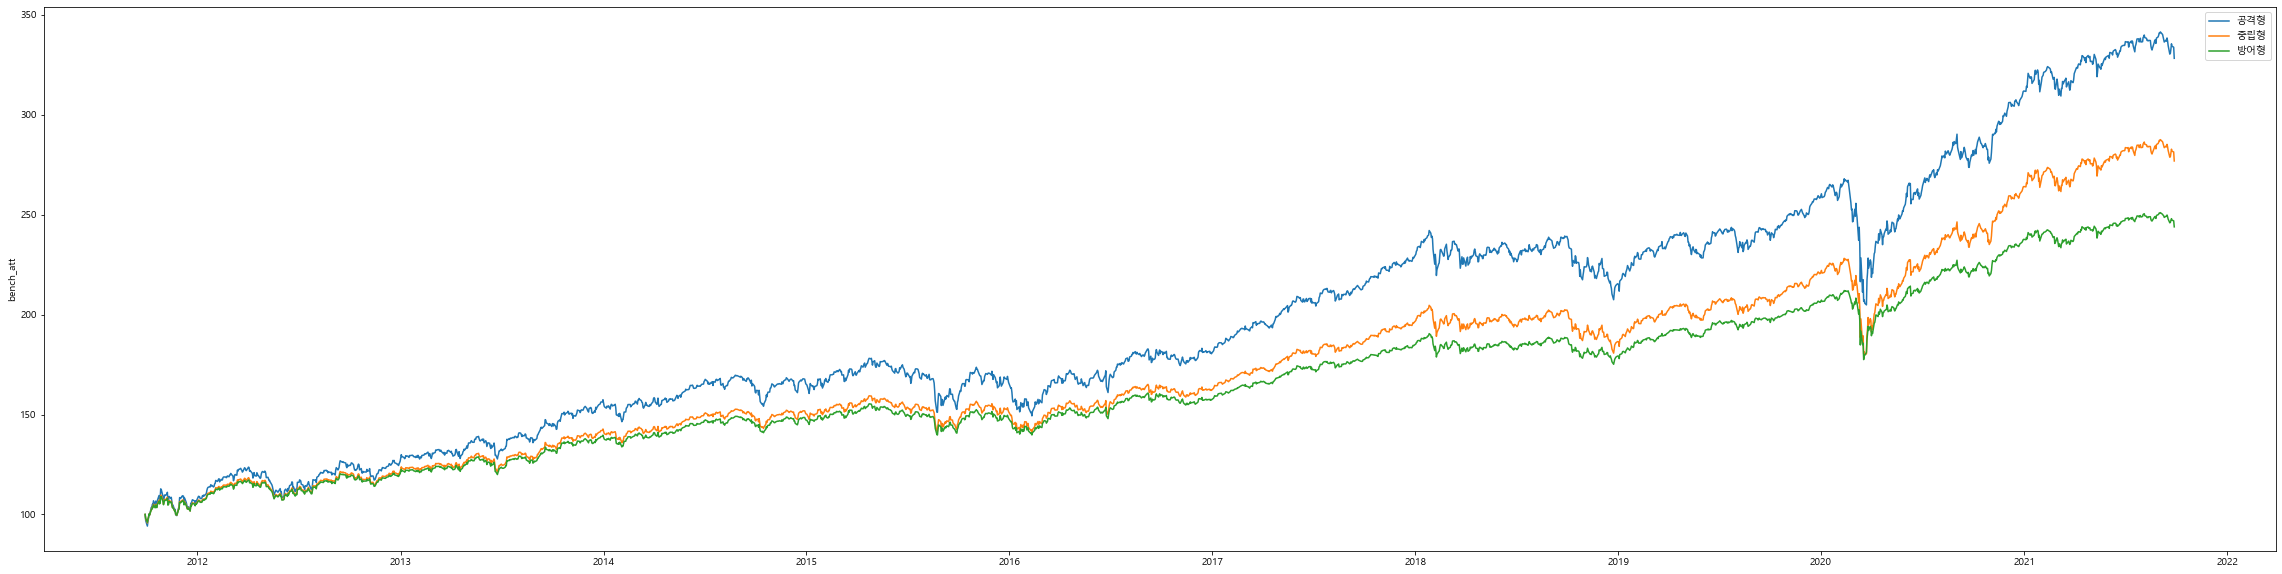

In [51]:
fig, ax = plt.subplots(figsize=(40, 10))
sns.lineplot(y='bench_att', label='공격형', x=bench_hv.index, data=bench_hv)
sns.lineplot(y='bench_neu', label='중립형', x=bench_hv.index, data=bench_hv)
sns.lineplot(y='bench_def', label='방어형', x=bench_hv.index, data=bench_hv)

<AxesSubplot:ylabel='bench_att_HV'>

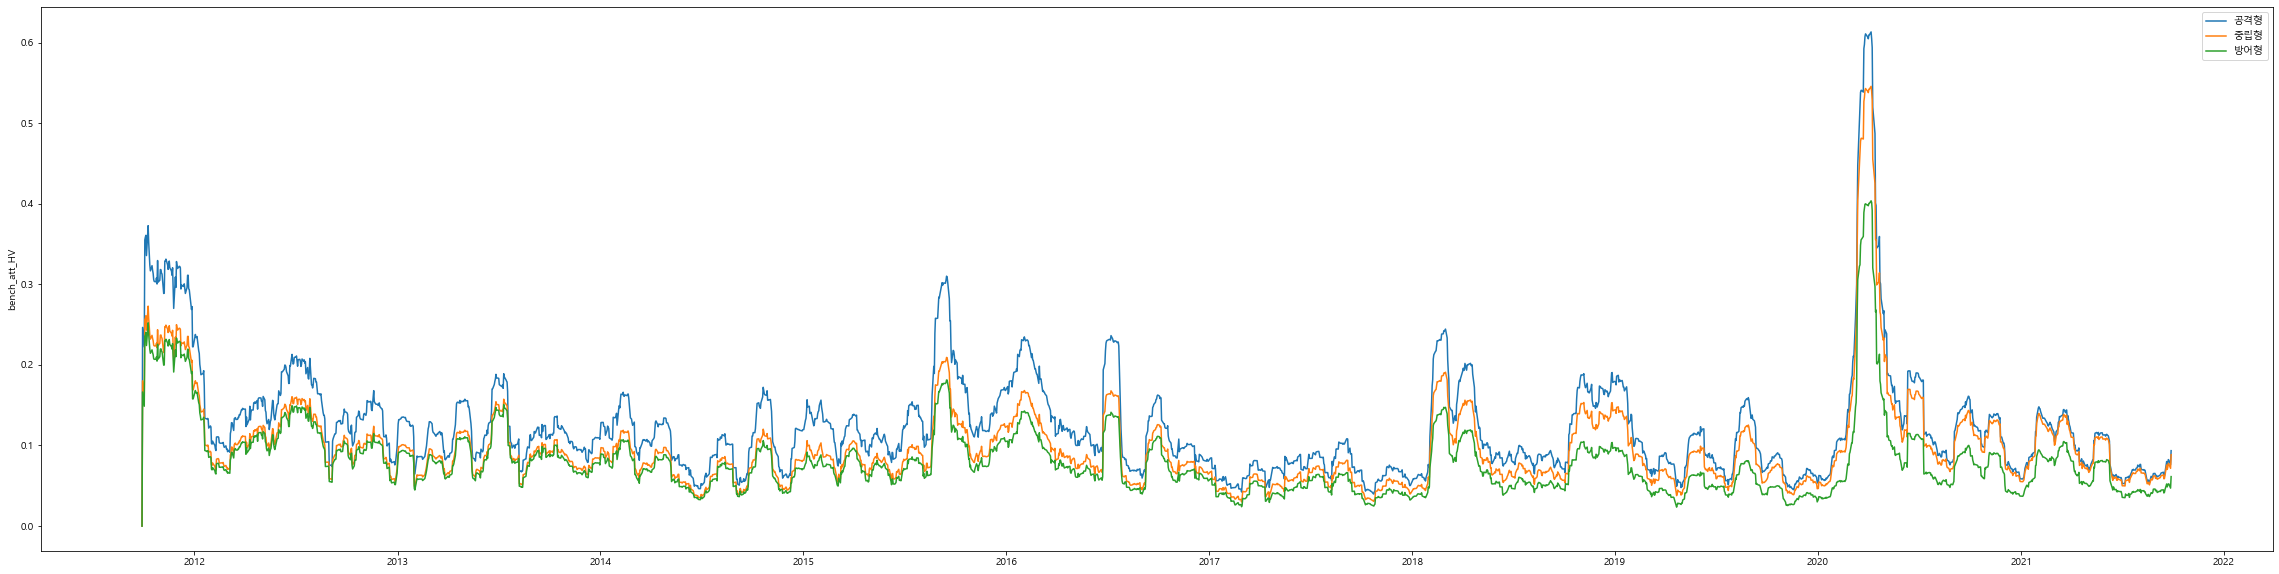

In [52]:
fig, ax = plt.subplots(figsize=(40, 10))
sns.lineplot(y='bench_att_HV', label='공격형', x=bench_hv.index, data=bench_hv)
sns.lineplot(y='bench_neu_HV', label='중립형', x=bench_hv.index, data=bench_hv)
sns.lineplot(y='bench_def_HV', label='방어형', x=bench_hv.index, data=bench_hv)

# 리밸런싱 함수

In [53]:
def getOutSignal(a, b):
    if a <= b:
        result = 1
    else:
        result = 0
    return result

def getOutDate(a, b):
    if (a == 1) & (b ==0):
        result = 1
    else:
        result = 0
    return result

def getRebalancedGlidePath(
    portfolio_hv, glide_path, 
    resid_diff, 
    out_multiple, in_multiple, 
    rebalance_weight, period, 
    end_date_1p_bt, start_date_2p, 
    hv_resid_mean, hv_resid_std, 
):
    
    df = portfolio_hv.copy()
    df.columns = ['portfolio', 'HV', 'HV_resid_5', 'HV_resid_10', 'HV_resid_15', 'HV_resid_20']
    
    if resid_diff == 5:
        df = df[['portfolio', 'HV', 'HV_resid_5']]
        hv_resid_mean = hv_resid_mean[0]
        hv_resid_std  = hv_resid_std[0]
    elif resid_diff == 10:
        df = df[['portfolio', 'HV', 'HV_resid_10']]
        hv_resid_mean = hv_resid_mean[1]
        hv_resid_std  = hv_resid_std[1]
    elif resid_diff == 15:
        df = df[['portfolio', 'HV', 'HV_resid_15']]
        hv_resid_mean = hv_resid_mean[2]
        hv_resid_std  = hv_resid_std[2]
    elif resid_diff == 20:
        df = df[['portfolio', 'HV', 'HV_resid_20']]
        hv_resid_mean = hv_resid_mean[3]
        hv_resid_std  = hv_resid_std[3]
    else:
        print('invalid resid diff')
    df.columns = ['portfolio', 'HV', 'HV_resid']
    
    gp = glide_path.copy()
    
    # 기존 글라이드 패스와 리밸런싱 일자를 구분하기 위한 컬럼
    gp['class'] = 'gp'
    
    # 리밸런싱 시그널
    df['HV_resid_signal'] = hv_resid_mean - out_multiple * hv_resid_std
    df['Out_signal'] = df.apply(lambda x: getOutSignal(x['HV_resid'], x['HV_resid_signal']), axis=1)
    df['Out_signal_shift'] = df['Out_signal'].shift(1)
    
    # 위험자산의 비중을 낮추는 일자
    df['Out_date'] = df.apply(lambda x: getOutDate(x['Out_signal'], x['Out_signal_shift']), axis=1)
    
    # 위험자산의 비중을 이전의 글라이드 패스로 복구할 일자
    df.reset_index(inplace=True)
    out_idx = df[df['Out_date'] == 1].index
    rb_idx  = []
    in_idx  = []
    for out_date_idx in out_idx:
        idx = out_date_idx
        try:
            while df.iloc[idx, 3] <= (hv_resid_mean + in_multiple * hv_resid_std):
                rb_idx.append(idx)
                idx = idx + 1
            in_idx.append(idx)
        except:
            continue
    df['In_date'] = 0
    df.iloc[in_idx, -1] = 1
    
    df['Rebalance'] = 0
    df.iloc[rb_idx, -1] = 1
    
    df.set_index('index', inplace=True)
    df['class'] = np.nan
    df.iloc[out_idx, -1] = 'out'
    df.iloc[in_idx,  -1] = 'in'
    
    history = df.copy()
    
    # 1기간, 2기간에 따라 글라이드 패스 리밸런싱 일자 구분 : 안함
    if period == 1:
        gp = gp # [:end_date_1p_bt]
        df = df # [:end_date_1p_bt]
        df = df[df['class'].notna()]
    elif period == 2:
        gp = gp
        df = df[start_date_2p:]
        df = df[df['class'].notna()]
        if df.iloc[0, -1] == 'in':
            df = df[1:]
    else:
        print('period error')
    
    
    # 기존 글라이드 패스에 리밸런싱 일자 추가
    gp = pd.concat([gp, df[df['class'].notna()][['class']]], axis=0).sort_index()
    gp.reset_index(inplace=True)
    i = 0
    drop_cnt = 0
    while i < gp.shape[0] + drop_cnt:
        if gp.loc[i, 'class'] == 'out':
            gp.loc[i, 'EWG'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWG']
            gp.loc[i, 'EWH'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWH']
            gp.loc[i, 'EWJ'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWJ']
            gp.loc[i, 'EWQ'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWQ']
            gp.loc[i, 'EWY'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWY']
            gp.loc[i, 'QQQ'] = (1 - rebalance_weight) * gp.loc[i - 1, 'QQQ']
            gp.loc[i, 'SPY'] = (1 - rebalance_weight) * gp.loc[i - 1, 'SPY']
            gp.loc[i, 'AGG'] = 1 - gp.loc[i, 'EWG':'SPY'].sum()
        elif gp.loc[i, 'class'] == 'in':
            if gp.loc[i - 1, 'class'] == 'gp':
                gp.loc[i, 'EWG'] = gp.loc[i - 1, 'EWG']
                gp.loc[i, 'EWH'] = gp.loc[i - 1, 'EWH']
                gp.loc[i, 'EWJ'] = gp.loc[i - 1, 'EWJ']
                gp.loc[i, 'EWQ'] = gp.loc[i - 1, 'EWQ']
                gp.loc[i, 'EWY'] = gp.loc[i - 1, 'EWY']
                gp.loc[i, 'QQQ'] = gp.loc[i - 1, 'QQQ']
                gp.loc[i, 'SPY'] = gp.loc[i - 1, 'SPY']
                gp.loc[i, 'AGG'] = gp.loc[i - 1, 'AGG']
                gp.drop(axis=0, index=[i - 1], inplace=True)
                drop_cnt = drop_cnt + 1
            elif gp.loc[i - 1, 'class'] == 'out':
                gp.loc[i, 'EWG'] = gp.loc[i - 2, 'EWG']
                gp.loc[i, 'EWH'] = gp.loc[i - 2, 'EWH']
                gp.loc[i, 'EWJ'] = gp.loc[i - 2, 'EWJ']
                gp.loc[i, 'EWQ'] = gp.loc[i - 2, 'EWQ']
                gp.loc[i, 'EWY'] = gp.loc[i - 2, 'EWY']
                gp.loc[i, 'QQQ'] = gp.loc[i - 2, 'QQQ']
                gp.loc[i, 'SPY'] = gp.loc[i - 2, 'SPY']
                gp.loc[i, 'AGG'] = gp.loc[i - 2, 'AGG']
        elif gp.loc[i, 'class'] == 'gp':
            pass
        i = i + 1
    gp.set_index('index', inplace=True)
    
    
    return gp, history

# 1기간 리밸런싱

In [54]:
# 고객에게 제안 가능한 조건
resid_diff = 20
out_multiple = 0.6
in_multiple  = 0
rebalance_weight = 0.4
period = 1

<AxesSubplot:xlabel='index', ylabel='Rebalance'>

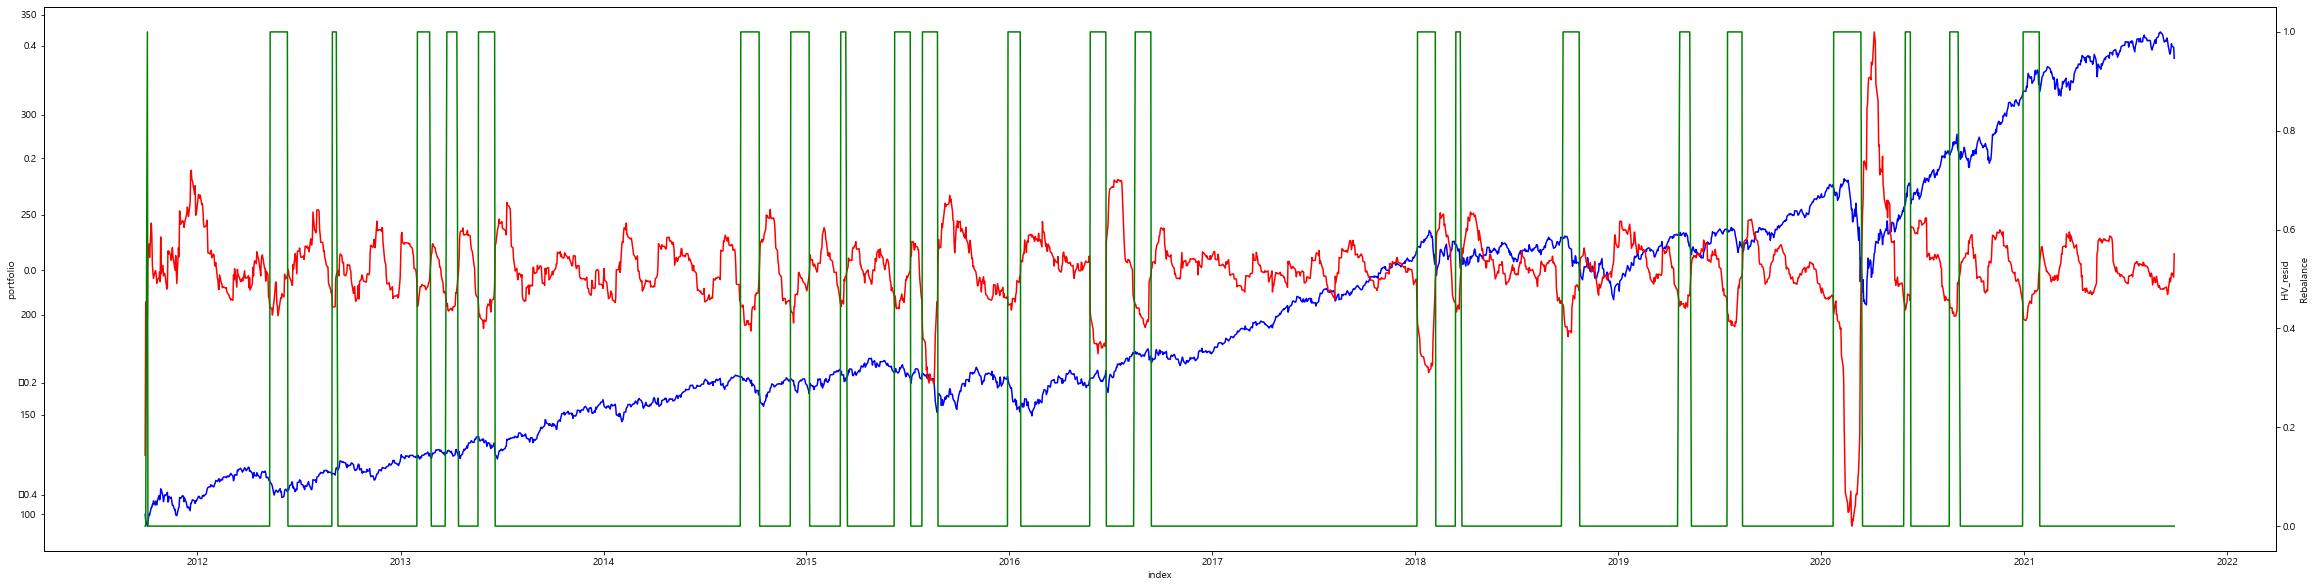

In [58]:
# 공격형 글라이드 패스 리밸런싱
gp_1p_att, history_1p_att = getRebalancedGlidePath(
    bench_hv[['bench_att', 'bench_att_HV', 'bench_att_HV_resid_5', 'bench_att_HV_resid_10', 'bench_att_HV_resid_15', 'bench_att_HV_resid_20']], 
    gp_bench_att, 
    resid_diff=resid_diff, 
    out_multiple=out_multiple, 
    in_multiple=in_multiple, 
    rebalance_weight=rebalance_weight, 
    period=period, 
    end_date_1p_bt=end_date_bt, start_date_2p=start_date_bt, 
    hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_1p_att['portfolio'], x=history_1p_att.index)
sns.lineplot(ax=ax2, color='r', y=history_1p_att['HV_resid'], x=history_1p_att.index)
sns.lineplot(ax=ax3, color='g', y=history_1p_att['Rebalance'], x=history_1p_att.index)

<AxesSubplot:xlabel='index', ylabel='Rebalance'>

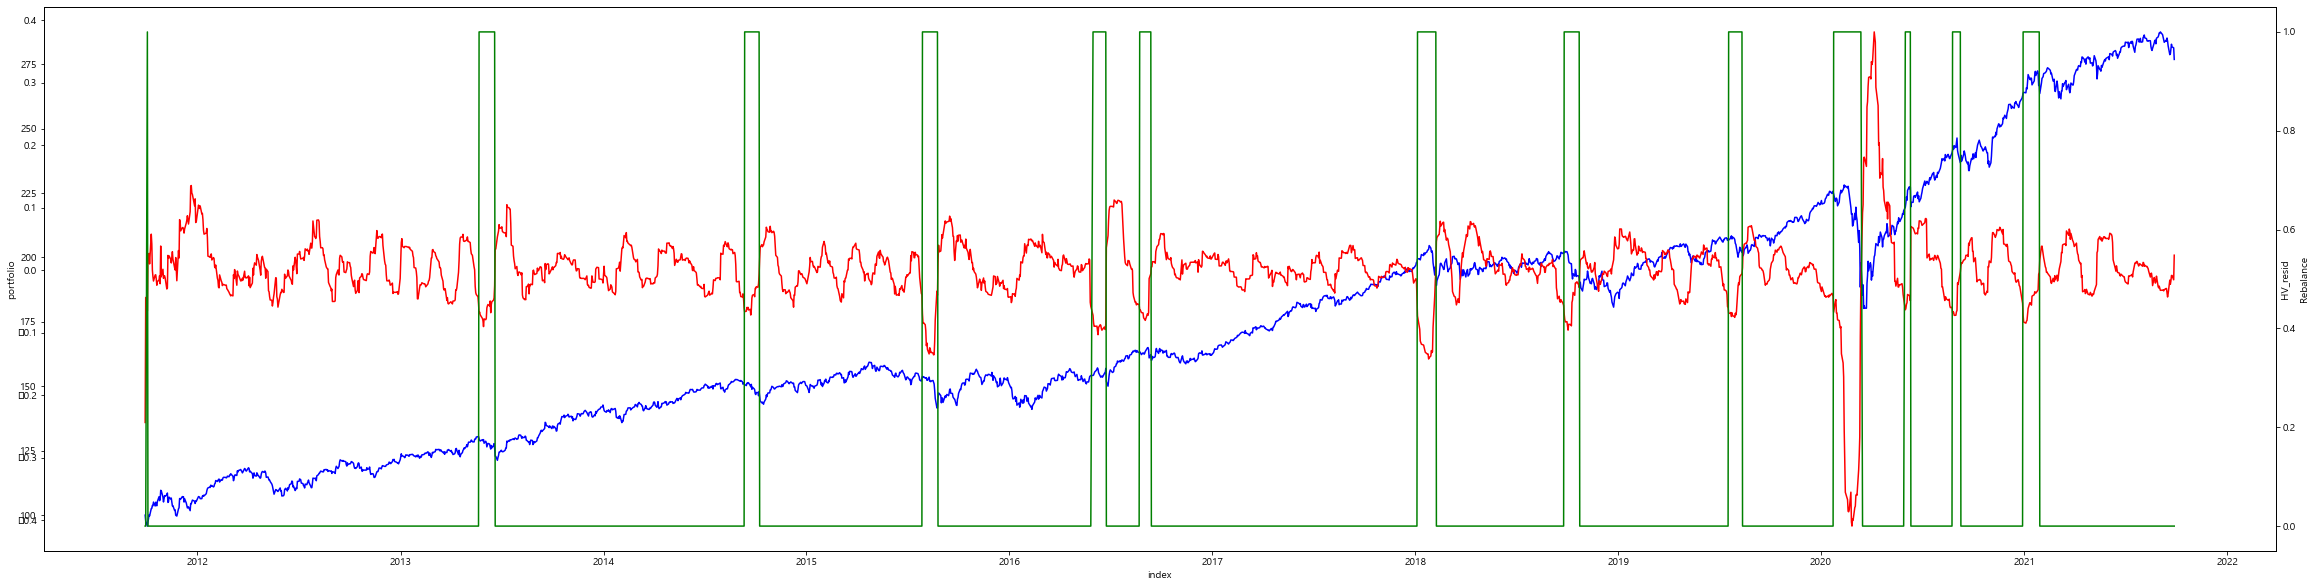

In [59]:
# 중립형 글라이드 패스 리밸런싱
gp_1p_neu, history_1p_neu = getRebalancedGlidePath(
    bench_hv[['bench_neu', 'bench_neu_HV', 'bench_neu_HV_resid_5', 'bench_neu_HV_resid_10', 'bench_neu_HV_resid_15', 'bench_neu_HV_resid_20']], 
    gp_bench_att, 
    resid_diff=resid_diff, 
    out_multiple=out_multiple, 
    in_multiple=in_multiple, 
    rebalance_weight=rebalance_weight, 
    period=period, 
    end_date_1p_bt=end_date_bt, start_date_2p=start_date_bt, 
    hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_1p_neu['portfolio'], x=history_1p_neu.index)
sns.lineplot(ax=ax2, color='r', y=history_1p_neu['HV_resid'], x=history_1p_neu.index)
sns.lineplot(ax=ax3, color='g', y=history_1p_neu['Rebalance'], x=history_1p_neu.index)

<AxesSubplot:xlabel='index', ylabel='Rebalance'>

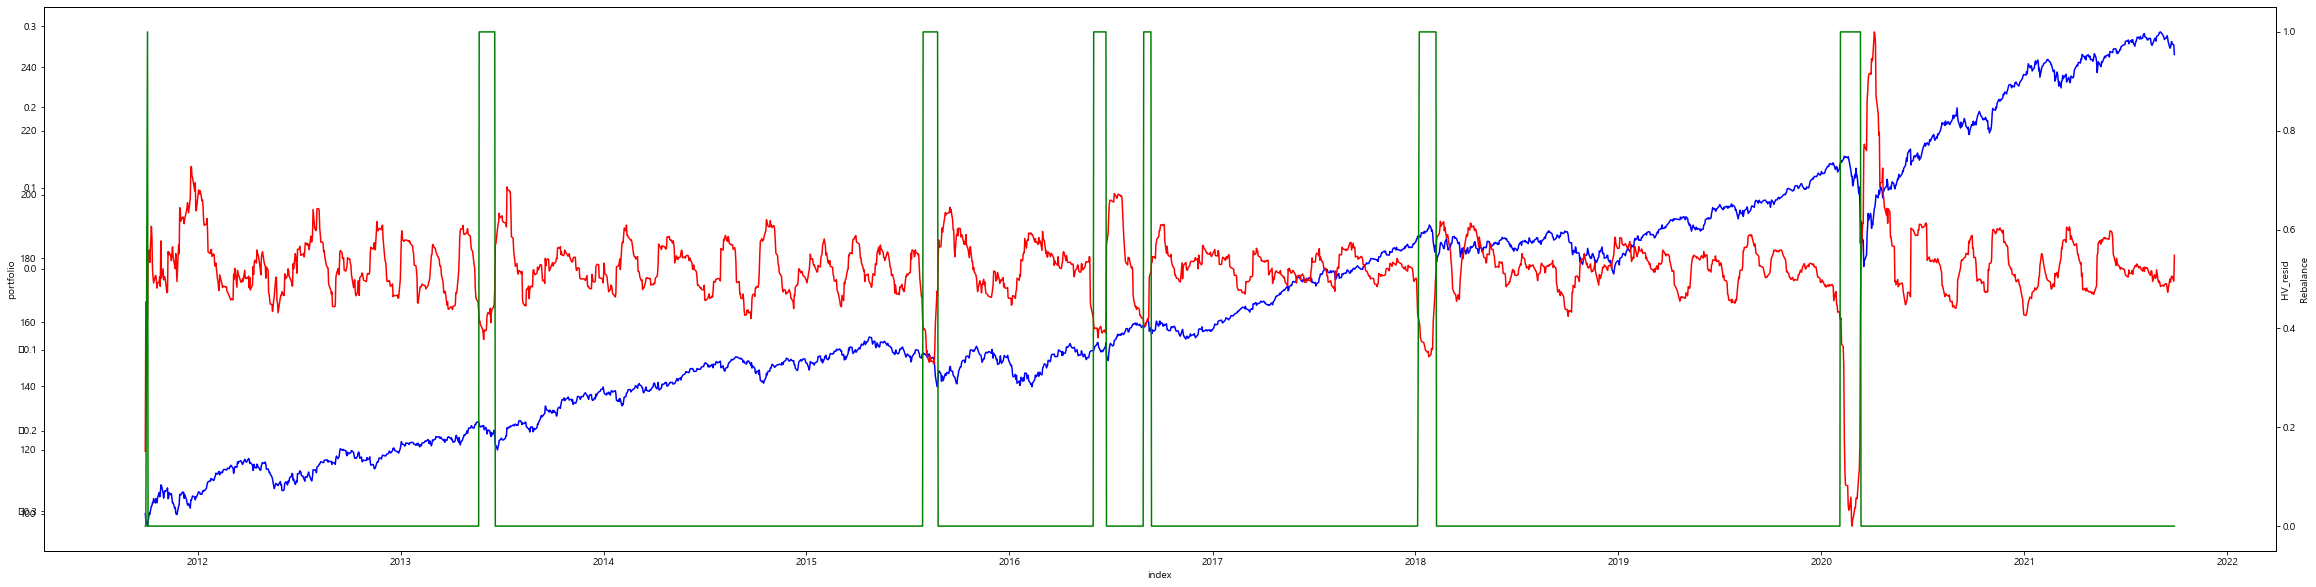

In [60]:
# 방어형 글라이드 패스 리밸런싱
gp_1p_def, history_1p_def = getRebalancedGlidePath(
    bench_hv[['bench_def', 'bench_def_HV', 'bench_def_HV_resid_5', 'bench_def_HV_resid_10', 'bench_def_HV_resid_15', 'bench_def_HV_resid_20']], 
    gp_bench_att, 
    resid_diff=resid_diff, 
    out_multiple=out_multiple, 
    in_multiple=in_multiple, 
    rebalance_weight=rebalance_weight, 
    period=period, 
    end_date_1p_bt=end_date_bt, start_date_2p=start_date_bt, 
    hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_1p_def['portfolio'], x=history_1p_def.index)
sns.lineplot(ax=ax2, color='r', y=history_1p_def['HV_resid'], x=history_1p_def.index)
sns.lineplot(ax=ax3, color='g', y=history_1p_def['Rebalance'], x=history_1p_def.index)

In [61]:
# 1기간 전략별 리밸런싱 횟수
print('공격형 : ', gp_1p_att[gp_1p_att['class'] == 'out'].shape[0])
print('중립형 : ', gp_1p_neu[gp_1p_neu['class'] == 'out'].shape[0])
print('방어형 : ', gp_1p_def[gp_1p_def['class'] == 'out'].shape[0])

공격형 :  34
중립형 :  17
방어형 :  9


In [62]:
data = etf['Adj Close'].loc[start_date_bt:end_date_bt]

p1_att = bt.Strategy(
    'p1_att', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_1p_att.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)

p1_neu = bt.Strategy(
    'p1_neu', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_1p_neu.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)

p1_def = bt.Strategy(
    'p1_def', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_1p_def.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)

p1_att_backtest = bt.Backtest(strategy=p1_att, data=data)
p1_neu_backtest = bt.Backtest(strategy=p1_neu, data=data)
p1_def_backtest = bt.Backtest(strategy=p1_def, data=data)

p1_result = bt.run(p1_att_backtest, p1_neu_backtest, p1_def_backtest)
p1_hv = p1_result.prices
p1_hv

,p1_att,p1_neu,p1_def
2011-09-28,100.000000,100.000000,100.000000
2011-09-29,100.000000,100.000000,100.000000
2011-09-30,96.894486,96.894486,96.894486
2011-10-03,94.167332,94.167332,94.167332
2011-10-04,95.389734,95.389734,95.389734
...,...,...,...
2021-09-22,416.638803,410.361266,361.299718
2021-09-23,419.509997,413.189319,364.149946
2021-09-24,418.147040,411.847043,362.784226
2021-09-27,417.534015,411.243197,362.329696


In [63]:
data = etf['Adj Close'].loc[start_date_bt:end_date_bt]

rb_bt_results = []
rows = []

for resid_diff in [5, 10]: #, 15, 20]:
    for out_multiple in [0.2, 0.3]: #, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]:
        for rebalance_weight in [0.2, 0.3]: #, 0.4, 0.5, 0.6, 0.7, 0.8]:
            
            att_row = []
            neu_row = []
            def_row = []
            
            gp_att, history_att = getRebalancedGlidePath(
                bench_hv[['bench_att', 'bench_att_HV', 'bench_att_HV_resid_5', 'bench_att_HV_resid_10', 'bench_att_HV_resid_15', 'bench_att_HV_resid_20']], 
                gp_bench_att, 
                resid_diff=resid_diff, 
                out_multiple=out_multiple, 
                in_multiple=in_multiple, 
                rebalance_weight=rebalance_weight, 
                period=period, 
                end_date_1p_bt=end_date_bt, start_date_2p=start_date_bt, 
                hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
            )
            gp_neu, history_neu = getRebalancedGlidePath(
                bench_hv[['bench_neu', 'bench_neu_HV', 'bench_neu_HV_resid_5', 'bench_neu_HV_resid_10', 'bench_neu_HV_resid_15', 'bench_neu_HV_resid_20']], 
                gp_bench_att, 
                resid_diff=resid_diff, 
                out_multiple=out_multiple, 
                in_multiple=in_multiple, 
                rebalance_weight=rebalance_weight, 
                period=period, 
                end_date_1p_bt=end_date_bt, start_date_2p=start_date_bt, 
                hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
            )
            gp_def, history_def = getRebalancedGlidePath(
                bench_hv[['bench_def', 'bench_def_HV', 'bench_def_HV_resid_5', 'bench_def_HV_resid_10', 'bench_def_HV_resid_15', 'bench_def_HV_resid_20']], 
                gp_bench_att, 
                resid_diff=resid_diff, 
                out_multiple=out_multiple, 
                in_multiple=in_multiple, 
                rebalance_weight=rebalance_weight, 
                period=period, 
                end_date_1p_bt=end_date_bt, start_date_2p=start_date_bt, 
                hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
            )
            
            att = bt.Strategy(
                'att', 
                algos=[
                    bt.algos.
                    bt.algos.SelectAll(), 
                    bt.algos.WeighTarget(gp_att.drop('class', axis=1)), 
                    bt.algos.Rebalance(), 
                ]
            )
            neu = bt.Strategy(
                'neu', 
                algos=[
                    bt.algos.
                    bt.algos.SelectAll(), 
                    bt.algos.WeighTarget(gp_neu.drop('class', axis=1)), 
                    bt.algos.Rebalance(), 
                ]
            )
            deff = bt.Strategy(
                'deff', 
                algos=[
                    bt.algos.
                    bt.algos.SelectAll(), 
                    bt.algos.WeighTarget(gp_def.drop('class', axis=1)), 
                    bt.algos.Rebalance(), 
                ]
            )
            
            att_backtest = bt.Backtest(strategy=att, data=data)
            neu_backtest = bt.Backtest(strategy=neu, data=data)
            def_backtest = bt.Backtest(strategy=deff, data=data)
            rb_bt_result = bt.run(att_backtest, neu_backtest, def_backtest)
            rb_bt_results.append(rb_bt_result)
            rb_bt_hv = rb_bt_result.prices
            
            att_row.append('att')
            att_row.append(rb_bt_hv.iloc[-1, 0])
            att_row.append(gp_att[gp_att['class'] == 'out'].shape[0])
            att_row.append(resid_diff)
            att_row.append(out_multiple)
            att_row.append(rebalance_weight)
            rows.append(att_row)
            
            neu_row.append('neu')
            neu_row.append(rb_bt_hv.iloc[-1, 1])
            neu_row.append(gp_neu[gp_neu['class'] == 'out'].shape[0])
            neu_row.append(resid_diff)
            neu_row.append(out_multiple)
            neu_row.append(rebalance_weight)
            rows.append(neu_row)
            
            def_row.append('deff')
            def_row.append(rb_bt_hv.iloc[-1, 2])
            def_row.append(gp_def[gp_def['class'] == 'out'].shape[0])
            def_row.append(resid_diff)
            def_row.append(out_multiple)
            def_row.append(rebalance_weight)
            rows.append(def_row)

rb_bt_stats = pd.DataFrame(rows, columns=['class', 'return', 'rb_count', 'resid_diff', 'out_multiple', 'rebalance_weight'])
rb_bt_stats

TypeError: cannot convert the series to <class 'float'>

In [68]:
bt.run(neu_backtest).prices

,neu
2011-09-28,100.000000
2011-09-29,100.000000
2011-09-30,96.894486
2011-10-03,94.167332
2011-10-04,96.395758
...,...
2018-09-24,247.098728
2018-09-25,247.293619
2018-09-26,247.479480
2018-09-27,248.200566


In [ ]:
len(p1_results)

In [ ]:
p1_results[195].prices

In [ ]:
p1_stats.sort_values('return', ascending=False).head(30)

In [ ]:
p1_stats.groupby('class').mean()

In [ ]:
p1_stats.groupby('resid_diff').mean().sort_values('return', ascending=False)

In [ ]:
p1_stats.groupby('out_multiple').mean().sort_values('return', ascending=False)

In [ ]:
p1_stats.groupby('rebalance_weight').mean().sort_values('return', ascending=False)

In [ ]:
p1_stats.describe()

In [ ]:
sns.relplot(
    data=p1_stats, x='rb_count', y='return', kind='scatter', 
    # col='resid_diff', 
    hue='rebalance_weight', 
    # col_wrap=2, 
)

# 2기간 리밸런싱

In [ ]:
# 고객에게 제안 가능한 조건
resid_diff = 20
out_multiple = 0.6
in_multiple  = 0
rebalance_weight = 0.4
period = 2

In [ ]:
gp_2p_att, history_2p_att = getRebalancedGlidePath(
    bench_hv[['bench_att', 'bench_att_HV', 'bench_att_HV_resid_5', 'bench_att_HV_resid_10', 'bench_att_HV_resid_15', 'bench_att_HV_resid_20']], 
    gp_bench_att, 
    resid_diff=resid_diff, 
    out_multiple=out_multiple, 
    in_multiple=in_multiple, 
    rebalance_weight=rebalance_weight, 
    period=period, 
    end_date_1p_bt=end_date_2p_bt, start_date_2p=start_date_2p, 
    hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_2p_att['portfolio'], x=history_2p_att.index)
sns.lineplot(ax=ax2, color='r', y=history_2p_att['HV_resid'], x=history_2p_att.index)
sns.lineplot(ax=ax3, color='g', y=history_2p_att['Rebalance'], x=history_2p_att.index)

In [ ]:
# 중립형 글라이드 패스 리밸런싱
gp_2p_neu, history_2p_neu = getRebalancedGlidePath(
    bench_hv[['bench_neu', 'bench_neu_HV', 'bench_neu_HV_resid_5', 'bench_neu_HV_resid_10', 'bench_neu_HV_resid_15', 'bench_neu_HV_resid_20']], 
    gp_bench_att, 
    resid_diff=resid_diff, 
    out_multiple=out_multiple, 
    in_multiple=in_multiple, 
    rebalance_weight=rebalance_weight, 
    period=period, 
    end_date_1p_bt=end_date_1p_bt, start_date_2p=start_date_2p, 
    hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_2p_neu['portfolio'], x=history_2p_neu.index)
sns.lineplot(ax=ax2, color='r', y=history_2p_neu['HV_resid'], x=history_2p_neu.index)
sns.lineplot(ax=ax3, color='g', y=history_2p_neu['Rebalance'], x=history_2p_neu.index)

In [ ]:
# 방어형 글라이드 패스 리밸런싱
gp_2p_def, history_2p_def = getRebalancedGlidePath(
    bench_hv[['bench_def', 'bench_def_HV', 'bench_def_HV_resid_5', 'bench_def_HV_resid_10', 'bench_def_HV_resid_15', 'bench_def_HV_resid_20']], 
    gp_bench_att, 
    resid_diff=resid_diff, 
    out_multiple=out_multiple, 
    in_multiple=in_multiple, 
    rebalance_weight=rebalance_weight, 
    period=period, 
    end_date_1p_bt=end_date_1p_bt, start_date_2p=start_date_2p, 
    hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_2p_def['portfolio'], x=history_2p_def.index)
sns.lineplot(ax=ax2, color='r', y=history_2p_def['HV_resid'], x=history_2p_def.index)
sns.lineplot(ax=ax3, color='g', y=history_2p_def['Rebalance'], x=history_2p_def.index)

In [ ]:
# 2기간 전략별 리밸런싱 횟수
print('공격형 : ', gp_2p_att[gp_2p_att['class'] == 'out'].shape[0])
print('중립형 : ', gp_2p_neu[gp_2p_neu['class'] == 'out'].shape[0])
print('방어형 : ', gp_2p_def[gp_2p_def['class'] == 'out'].shape[0])

In [ ]:
data = etf['Adj Close'].loc[start_date_1p:end_date_2p_bt]

p2_att = bt.Strategy(
    'p2_att', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_2p_att.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)

p2_neu = bt.Strategy(
    'p2_neu', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_2p_neu.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)

p2_def = bt.Strategy(
    'p2_def', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_2p_def.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)

p2_att_backtest = bt.Backtest(strategy=p2_att, data=data)
p2_neu_backtest = bt.Backtest(strategy=p2_neu, data=data)
p2_def_backtest = bt.Backtest(strategy=p2_def, data=data)

p2_result = bt.run(p2_att_backtest, p2_neu_backtest, p2_def_backtest)
p2_hv = p2_result.prices
p2_hv

In [ ]:
data = etf['Adj Close'].loc[start_date_1p:end_date_2p_bt]

p2_results = []
rows = []

for resid_diff in [5, 10, 15, 20]:
    for out_multiple in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]:
        for rebalance_weight in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
            
            att_row = []
            neu_row = []
            def_row = []
            
            gp_2p_att, history_2p_att = getRebalancedGlidePath(
                bench_hv[['bench_att', 'bench_att_HV', 'bench_att_HV_resid_5', 'bench_att_HV_resid_10', 'bench_att_HV_resid_15', 'bench_att_HV_resid_20']], 
                gp_bench_att, 
                resid_diff=resid_diff, 
                out_multiple=out_multiple, 
                in_multiple=in_multiple, 
                rebalance_weight=rebalance_weight, 
                period=period, 
                end_date_1p_bt=end_date_1p_bt, start_date_2p=start_date_2p, 
                hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
            )
            gp_2p_neu, history_2p_neu = getRebalancedGlidePath(
                bench_hv[['bench_neu', 'bench_neu_HV', 'bench_neu_HV_resid_5', 'bench_neu_HV_resid_10', 'bench_neu_HV_resid_15', 'bench_neu_HV_resid_20']], 
                gp_bench_att, 
                resid_diff=resid_diff, 
                out_multiple=out_multiple, 
                in_multiple=in_multiple, 
                rebalance_weight=rebalance_weight, 
                period=period, 
                end_date_1p_bt=end_date_1p_bt, start_date_2p=start_date_2p, 
                hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
            )
            gp_2p_def, history_2p_def = getRebalancedGlidePath(
                bench_hv[['bench_def', 'bench_def_HV', 'bench_def_HV_resid_5', 'bench_def_HV_resid_10', 'bench_def_HV_resid_15', 'bench_def_HV_resid_20']], 
                gp_bench_att, 
                resid_diff=resid_diff, 
                out_multiple=out_multiple, 
                in_multiple=in_multiple, 
                rebalance_weight=rebalance_weight, 
                period=period, 
                end_date_1p_bt=end_date_1p_bt, start_date_2p=start_date_2p, 
                hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
            )
            
            p2_att = bt.Strategy(
                'p2_att', 
                algos=[
                    bt.algos.
                    bt.algos.SelectAll(), 
                    bt.algos.WeighTarget(gp_2p_att.drop('class', axis=1)), 
                    bt.algos.Rebalance(), 
                ]
            )
            p2_neu = bt.Strategy(
                'p2_neu', 
                algos=[
                    bt.algos.
                    bt.algos.SelectAll(), 
                    bt.algos.WeighTarget(gp_2p_neu.drop('class', axis=1)), 
                    bt.algos.Rebalance(), 
                ]
            )
            p2_def = bt.Strategy(
                'p2_def', 
                algos=[
                    bt.algos.
                    bt.algos.SelectAll(), 
                    bt.algos.WeighTarget(gp_2p_def.drop('class', axis=1)), 
                    bt.algos.Rebalance(), 
                ]
            )
            
            p2_att_backtest = bt.Backtest(strategy=p2_att, data=data)
            p2_neu_backtest = bt.Backtest(strategy=p2_neu, data=data)
            p2_def_backtest = bt.Backtest(strategy=p2_def, data=data)
            p2_result = bt.run(p2_att_backtest, p2_neu_backtest, p2_def_backtest)
            p2_results.append(p2_result)
            p2_hv = p2_result.prices
            
            att_row.append('att')
            att_row.append(p2_hv.iloc[-1, 0])
            att_row.append(gp_2p_att[gp_2p_att['class'] == 'out'].shape[0])
            att_row.append(resid_diff)
            att_row.append(out_multiple)
            att_row.append(rebalance_weight)
            rows.append(att_row)
            
            neu_row.append('neu')
            neu_row.append(p2_hv.iloc[-1, 1])
            neu_row.append(gp_2p_neu[gp_2p_neu['class'] == 'out'].shape[0])
            neu_row.append(resid_diff)
            neu_row.append(out_multiple)
            neu_row.append(rebalance_weight)
            rows.append(neu_row)
            
            def_row.append('def')
            def_row.append(p2_hv.iloc[-1, 2])
            def_row.append(gp_2p_def[gp_2p_def['class'] == 'out'].shape[0])
            def_row.append(resid_diff)
            def_row.append(out_multiple)
            def_row.append(rebalance_weight)
            rows.append(def_row)

p2_stats = pd.DataFrame(rows, columns=['class', 'return', 'rb_count', 'resid_diff', 'out_multiple', 'rebalance_weight'])
p2_stats

In [ ]:
len(p2_results)